<a href="https://colab.research.google.com/github/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/blob/main/Notebooks/2_Descriptiva_vehiculos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 2: Análisis descriptivo de la circulación vehicular
##Librerías y datos que se utilizarán en la notebook

En primer lugar cargamos las librerías necesarias.
Además, se descarga el repositorio de este práctico (https://github.com/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos) donde se encuentran todos los datos que se usarán.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import numpy as np
from scipy.stats import pearsonr

!git clone https://github.com/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos.git

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Cloning into 'Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 167 (delta 15), reused 4 (delta 4), pack-reused 144
Receiving objects: 100% (167/167), 29.64 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (64/64), done.


#Análisis preliminar de la confiabilidad/veracidad de los datos
En esta sección, antes de empezar a analizar los datos de conteo vehicular de los peajes de CABA, vamos a poner a prueba la confiabilidad de la información que brindan las fuentes. Si bien, a priori, no tenemos motivos para desconfiar de la veracidad de la información brindada, es una buena práctica realizar ensayos de este tipo. En este trabajo no se cuantificará la confiabilidad de tal información sino que se hará de forma cualitativa.

Para hacerlo, se realizarán dos comparaciones distintas:


1.   Conteo vehicular en peajes vs. volumen de combustible vendido en CABA
2.   Conteo vehicular en peajes vs. mobilidad de la población en CABA

##1. Conteo vehicular en peajes vs. volumen de combustible vendido en CABA
En esta primer comparación, observaremos la relación entre el conteo vehicular y el volumen de combustibles vendidos. Nuestra hipótesis inicial es que estas dos variables están estrechamente correlacionadas. Lógicamente, esperamos ver que a mayor conteo vehicular, mayor es el consumo de combustibles. De conocer como debe ser el resultado a obtener y de efectivamente obtenerlo, la confiabilidad de los datos será mayor.

En primer lugar se cargan los datos de combusstibles:

In [ ]:
combustibles = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/combustibles.csv')
combustibles

,anio,mes,producto,volumen
0,2019,1,GNC,1.373439e+07
1,2019,1,Nafta (premium) de más de 95 Ron,1.965211e+04
2,2019,1,Nafta (súper) entre 92 y 95 Ron,4.272068e+04
3,2019,2,GNC,1.304179e+07
4,2019,2,Nafta (premium) de más de 95 Ron,1.946279e+04
...,...,...,...,...
67,2020,11,Nafta (premium) de más de 95 Ron,1.852527e+04
68,2020,11,Nafta (súper) entre 92 y 95 Ron,3.464911e+04
69,2020,12,GNC,1.340952e+07
70,2020,12,Nafta (premium) de más de 95 Ron,2.281999e+04


Y luego los de vehiculos, agrupando los conteos en una suma por mes, a fin de igualar las resoluciones temporales de ambas tablas

In [ ]:
vehiculos = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/flujo-vehicular-2019-2020.csv')
vehiculos['fecha_hora'] = pd.to_datetime(vehiculos['fecha_hora'], format = '%Y-%m-%d %H:%M:%S')
vehiculos['anio'] = pd.DatetimeIndex(vehiculos['fecha_hora']).year
vehiculos['mes'] = pd.DatetimeIndex(vehiculos['fecha_hora']).month
vehiculos = vehiculos[['anio', 'mes', 'cantidad_pasos']].groupby(['anio', 'mes'], as_index = False).sum()
vehiculos

,anio,mes,cantidad_pasos
0,2019,1,9681062.0
1,2019,2,9279669.0
2,2019,3,10596342.0
3,2019,4,9852378.0
4,2019,5,10711309.0
5,2019,6,10101566.0
6,2019,7,11039429.0
7,2019,8,11103630.0
8,2019,9,10880211.0
9,2019,10,11075826.0


Se juntan ambas tablas y se grafica el conteo vehicular vs el volumen de combustible vendido para cada tipo de combustible:


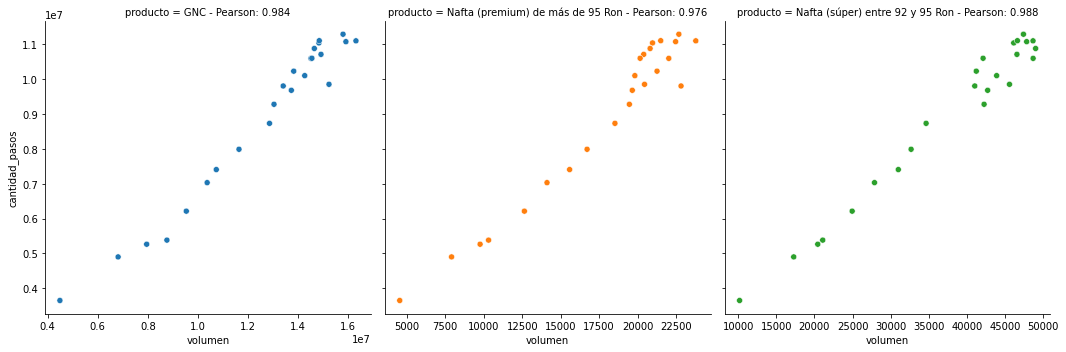

In [ ]:
vehiculos_combustibles = vehiculos.merge(combustibles, on = ['anio', 'mes'], how = "left")

productos = np.unique(vehiculos_combustibles['producto'])

for producto in productos:
  r_pearson, pvalue = pearsonr(vehiculos_combustibles[vehiculos_combustibles['producto'] == producto]['cantidad_pasos'], vehiculos_combustibles[vehiculos_combustibles['producto'] == producto]['volumen'])
  m = vehiculos_combustibles['producto'] == producto
  vehiculos_combustibles.loc[m, 'producto'] = vehiculos_combustibles.loc[m, 'producto'].astype(str) + ' - Pearson: ' + str(round(r_pearson, 3))


grafico = sns.relplot(data=vehiculos_combustibles, x='volumen', y='cantidad_pasos', hue='producto', col = 'producto', facet_kws=dict(sharex=False))
grafico._legend.remove()
plt.show()

##2. Conteo vehicular en peajes vs. movilidad de la población en CABA
Esta segunda comparación se realizará de forma similar a la primera y tiene el mismo objetivo. Buscaremos la relación existente entre la movildiad registrada por los reportes de movilidad de Google y el conteo de pasos de vehículos por los peajes de CABA.

Google comparte la movilidad de sus usuarios de forma anónima. El valor que entregan es el porcentaje de teléfonos móviles que se encuentran en un área asociada a una actividad en comparación a un valor base (primeros meses del 2020), estas actividades son:


*   Comercio y actividades recreativas
*   Comercio de alimentos y farmacia
*   Parques
*   Estaciones centrales de tránsito
*   Lugares de trabajo
*   Zonas residenciales

Para este ejemplo sólo utilizaremos la información de las zonas residenciales, entendiendo que a menor cantidad de personas en zonas residenciales, mayor será la circulación.

En primer lugar leemos los datos, se filtra la información que precisamos y se agrega una columna que indica si el dia es día de semana o fin de semana:


In [ ]:
movilidad = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/movilidad-buenos-aires.csv')[['date', 'residential_percent_change_from_baseline']].rename(columns = {'residential_percent_change_from_baseline': "residencial_porcentaje"})
movilidad['date'] = pd.to_datetime(movilidad['date'], format = '%Y-%m-%d')
movilidad["es_finde"] = movilidad['date'].dt.dayofweek > 4

movilidad

,date,residencial_porcentaje,es_finde
0,2020-02-15,0.0,True
1,2020-02-16,2.0,True
2,2020-02-17,2.0,False
3,2020-02-18,-1.0,False
4,2020-02-19,-2.0,False
...,...,...,...
316,2020-12-27,9.0,True
317,2020-12-28,13.0,False
318,2020-12-29,12.0,False
319,2020-12-30,10.0,False


De forma similar al punto anterior, se leen los datos de vehículos y se los agrupa por día, dado que esa es la resolución temporal que poseen los datos de movilidad:

In [ ]:
vehiculos = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/flujo-vehicular-2019-2020.csv')
vehiculos['fecha_hora'] = pd.to_datetime(vehiculos['fecha_hora'], format = '%Y-%m-%d %H:%M:%S')
vehiculos['date'] = pd.to_datetime(vehiculos['fecha_hora'].dt.date, format = '%Y-%m-%d')
vehiculos = vehiculos[['date', 'cantidad_pasos']].groupby(['date'], as_index = False).sum()
vehiculos

,date,cantidad_pasos
0,2019-01-01,208866.0
1,2019-01-02,378827.0
2,2019-01-03,394887.0
3,2019-01-04,368028.0
4,2019-01-05,200453.0
...,...,...
726,2020-12-27,193752.0
727,2020-12-28,348772.0
728,2020-12-29,372050.0
729,2020-12-30,378199.0


Realizo un gráfico similar al anterior

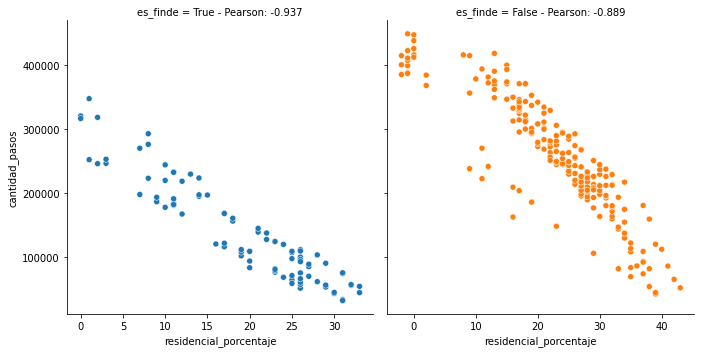

In [ ]:
vehiculos_movilidad = movilidad.merge(vehiculos, on = ['date'], how = "left")

productos = np.unique(vehiculos_movilidad['es_finde'])

for producto in productos:
  r_pearson, pvalue = pearsonr(vehiculos_movilidad[vehiculos_movilidad['es_finde'] == producto]['cantidad_pasos'], vehiculos_movilidad[vehiculos_movilidad['es_finde'] == producto]['residencial_porcentaje'])
  m = vehiculos_movilidad['es_finde'] == producto
  vehiculos_movilidad.loc[m, 'es_finde'] = vehiculos_movilidad.loc[m, 'es_finde'].astype(str) + ' - Pearson: ' + str(round(r_pearson, 3))


grafico = sns.relplot(data=vehiculos_movilidad, x='residencial_porcentaje', y='cantidad_pasos', hue='es_finde', col = 'es_finde', facet_kws=dict(sharex=False))
grafico._legend.remove()
plt.show()

##3. Conclusión
Estos resultados preliminares y rápidos nos aportan información sobre la confiabilidad del dataset de conteo vehicular que será utilizado a lo largo de toda la práctica.

Comparamos 3 formas distintas de medir la intensidad de circulación en CABA, cada una de una fuente y con una resolución y extensión diferente. Sin embargo, con un ensayo tan sencillo como lo es la correlación lineal, pudimos observar asociaciones muy intensas, indicando que la información provista por estos 3 sets de datos es similar. 

Entonces ¿podemos decir con total confianza que el conteo vehicular registrado es un buen indicador de la circulación vehicular dentro de la ciudad? No, para eso son necesarios experimentos más exhaustivos. Sin embargo, las fuertes relaciones observadas aumentan la probabilidad cualitativa de que el conteo vehicular registrado es un buen indicador de la circulación vehicular.

#Análisis exploratorio de los datos de circulación vehicular
##1. Cargar los datos preprocesados y leerlos


In [ ]:
vehiculos = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/flujo-vehicular-2019-2020.csv')
vehiculos['fecha_hora'] = pd.to_datetime(vehiculos['fecha_hora'], format = '%Y-%m-%d %H:%M:%S')
vehiculos

,fecha_hora,cantidad_pasos
0,2019-01-01 00:00:00,2275.0
1,2019-01-01 01:00:00,9389.0
2,2019-01-01 02:00:00,12809.0
3,2019-01-01 03:00:00,8796.0
4,2019-01-01 04:00:00,4863.0
...,...,...
17539,2020-12-31 19:00:00,14101.0
17540,2020-12-31 20:00:00,15301.0
17541,2020-12-31 21:00:00,10420.0
17542,2020-12-31 22:00:00,2821.0


##2. Graficación de datos observados
En primer lugar se graficarán los datos observados durante todo el período de estudio (01/01/2019 - 31/12/2020). Recuerde que se tratan de datos horarios

(array([737060., 737150., 737241., 737333., 737425., 737516., 737607.,
        737699., 737791.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 1.0, 'Figura 1: Circulación vehicular horaria observada 2019-2020')

Text(0.5, 0, 'Fecha y hora')

Text(0, 0.5, 'Conteo de vehículos')

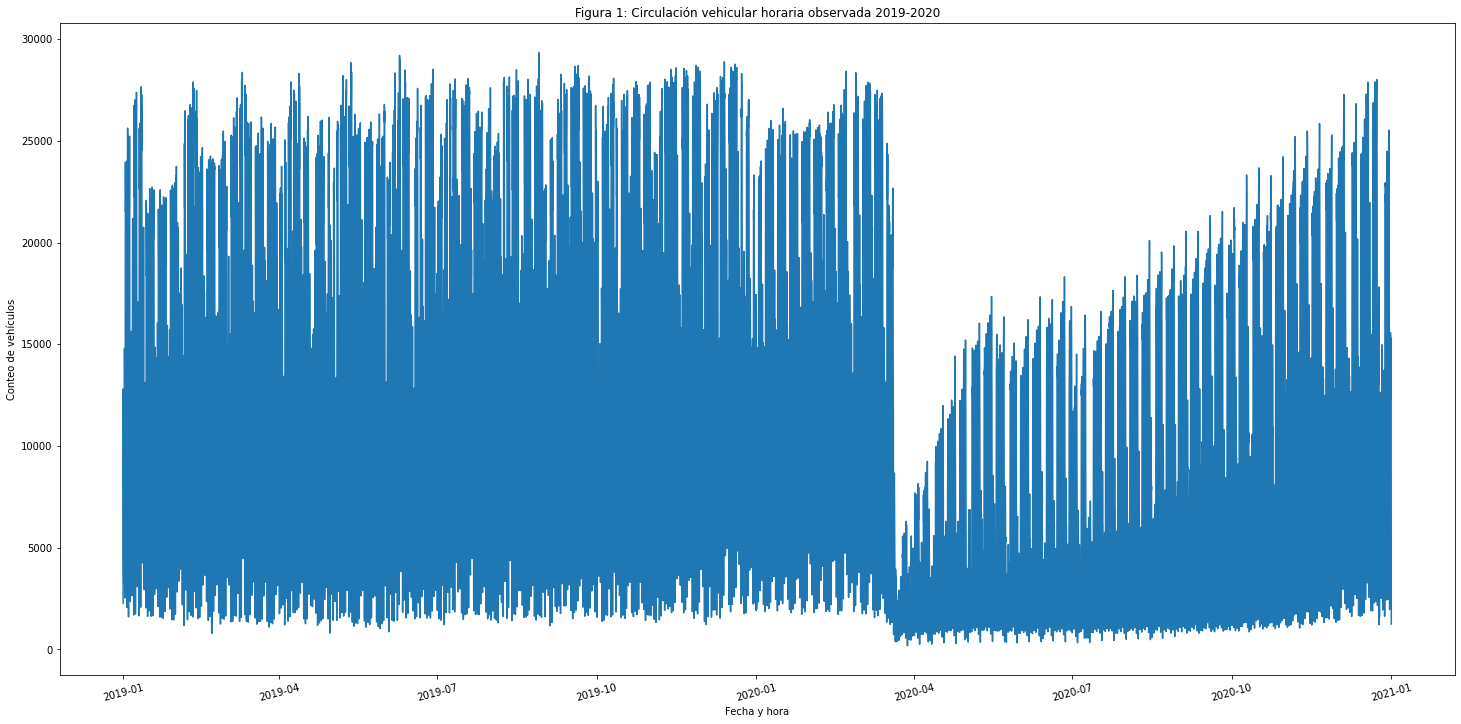

In [ ]:
plt.rcParams['figure.figsize'] = [25, 12]
sns.lineplot(x="fecha_hora", y="cantidad_pasos", data=vehiculos)
plt.xticks(rotation=15)
plt.title('Figura 1: Circulación vehicular horaria observada 2019-2020')
plt.xlabel("Fecha y hora")
plt.ylabel("Conteo de vehículos")
plt.show()




*   ¿Que puede observarse en el gráfico? 
*   ¿Cuantos datos se están graficando?
*   ¿Es útil esta figura para observar tenencias? y estacionalidades?

Realicemos el mismo gráfico pero para un intervalo de fechas más acotado. Explore diferentes intervalos de fechas modificandolas en el código a continación siempre respetando el formato 'YYYY-MM-DD'

(array([737282. , 737282.5, 737283. , 737283.5, 737284. , 737284.5,
        737285. ]), <a list of 7 Text major ticklabel objects>)

Text(0.5, 1.0, 'Figura 2: Circulación vehicular horaria observada entre 2019-08-11 y 2019-08-14')

Text(0.5, 0, 'Fecha y hora')

Text(0, 0.5, 'Conteo de vehículos')

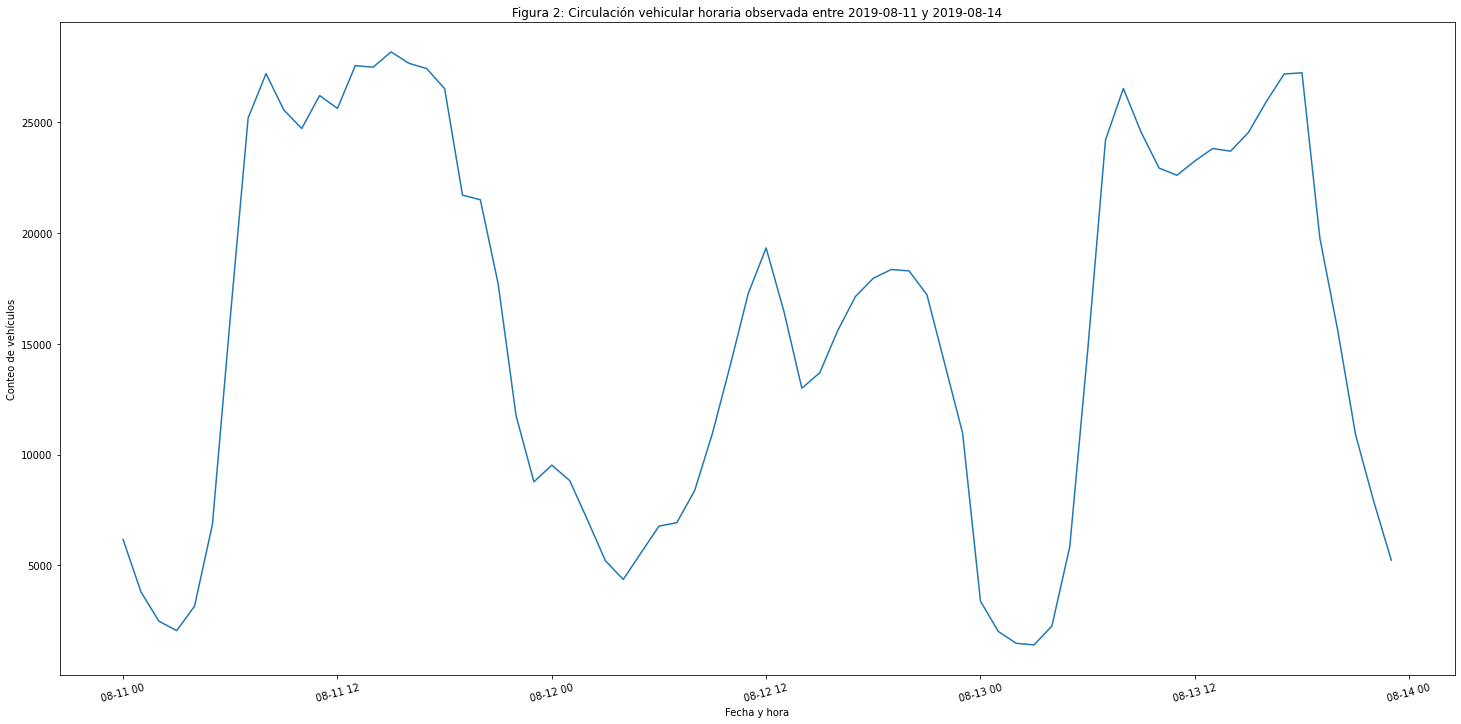

In [ ]:
##### Modifique las siguientes líneas de código #####
fecha_inicial = '2019-08-11'
fecha_final = '2019-08-14'



##### NO modifique las siguientes líneas de código #####
vehiculos_acotado = vehiculos[(vehiculos['fecha_hora'] >= fecha_inicial) & (vehiculos['fecha_hora'] < fecha_final)]

sns.lineplot(x="fecha_hora", y="cantidad_pasos", data=vehiculos_acotado)
plt.xticks(rotation=15)
plt.title('Figura 2: Circulación vehicular horaria observada entre ' + fecha_inicial + ' y ' + fecha_final)
plt.xlabel("Fecha y hora")
plt.ylabel("Conteo de vehículos")
plt.show()
plt.rcParams['figure.figsize'] = [25, 10]



*   ¿Como pareciera ser el comportamiento diario? ¿Era esperable?
*   ¿Es diferente el comportamiento de los días de la semana frente a los fines de semana?
*   ¿Que pasa durante un feriado? ¿Son todos los feriados iguales?
*   La cuarentena estricta inició el 20 de marzo de 2020. ¿Que tan rápido fue la respuesta de la población a esta medida?


Dada la resolución temporal de los datos, es difícil observar tendencias a mayor escala, por lo que suele ser útil agregar los datos a resoluciones menores.

Para la siguiente figura, los datos fueron agregados a datos diarios (se sumaron los conteos horarios para cada día), es decir que cada día tiene un solo conteo vehicular total. Repita el ejercicio anterior con los datos en esta resolución temporal:



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(array([737470., 737471., 737472., 737473., 737474., 737475., 737476.,
        737477.]), <a list of 8 Text major ticklabel objects>)

Text(0.5, 1.0, 'Figura 2: Circulación vehicular diaria observada entre 2020-02-15 y 2020-02-23')

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Conteo de vehículos')

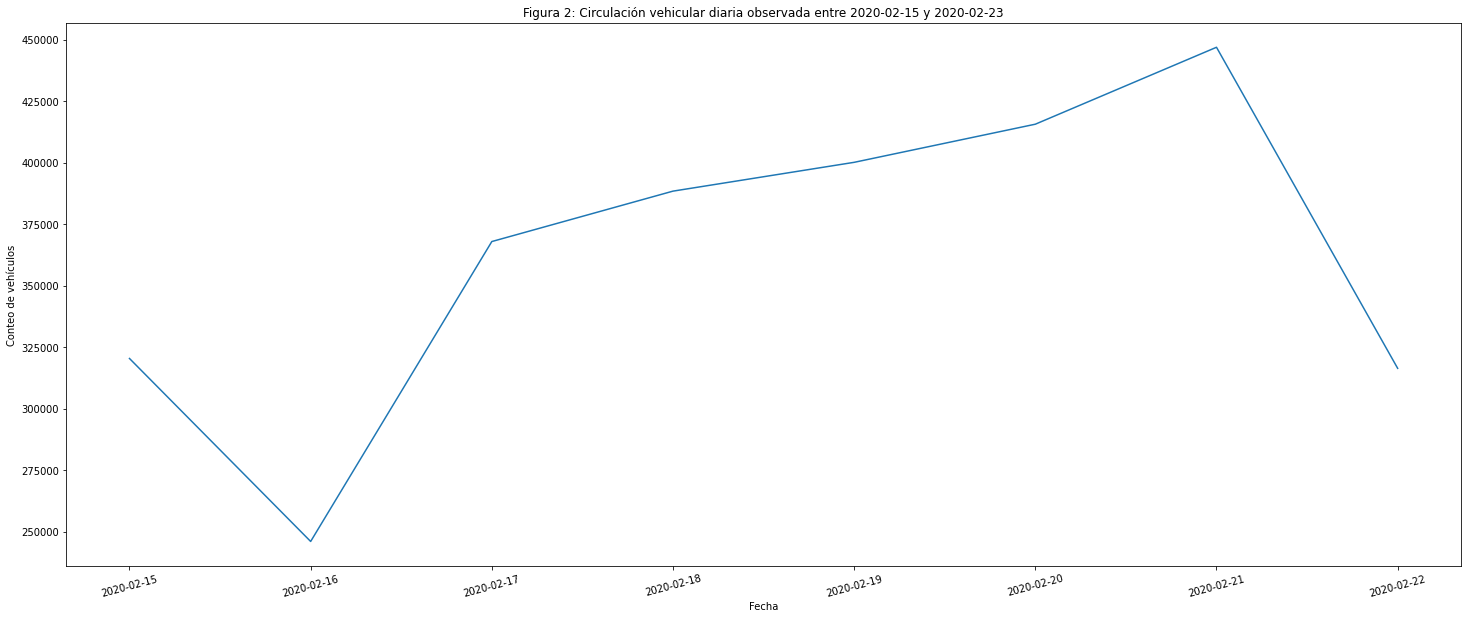

In [ ]:
##### Modifique las siguientes líneas de código #####
fecha_inicial = '2020-02-15'
fecha_final = '2020-02-23'



##### NO modifique las siguientes líneas de código #####
vehiculos_acotado = vehiculos[(vehiculos['fecha_hora'] >= fecha_inicial) & (vehiculos['fecha_hora'] < fecha_final)]

vehiculos_acotado['fecha'] = vehiculos_acotado['fecha_hora'].dt.date
vehiculos_acotado = vehiculos_acotado[['fecha', 'cantidad_pasos']].groupby(['fecha'], as_index = False).sum()

plt.rcParams['figure.figsize'] = [25, 10]
sns.lineplot(x="fecha", y="cantidad_pasos", data=vehiculos_acotado)
plt.xticks(rotation=15)
plt.title('Figura 2: Circulación vehicular diaria observada entre ' + fecha_inicial + ' y ' + fecha_final)
plt.xlabel("Fecha")
plt.ylabel("Conteo de vehículos")
plt.show()

*   ¿Como pareciera ser el comportamiento semanal? ¿Y el mensual?
*   ¿Que pasa durante un feriado? ¿Son todos los feriados iguales?
*   La cuarentena estricta inició el 20 de marzo de 2020. ¿Se modificó la estacionalidad semanal durante la cuarentena? ¿Y la tendencia general?

Otra manera de observar de forma descriptiva tendencias a diferentes escalas es aplicar medias móviles. Este cálculo toma una ventana de ancho (período de tiempo) fijo y agrupa datos de fechas consecutivas. Para cada tiempo, calcula la media de los datos que se encuentran en esa ventana. El resultado es una serie de medias que, dependiendo del ancho de la ventana, suavizan las fluctuaciones a corto-mediano-largo plazo, resaltando tendencias y ciclos o estacionalidades.

En el siguiente ejercicio, usted debe modificar el valor de _ancho_ventana_ y visualizar como se altera el comportamiento de la variable de conteo de vehículos. Recuerde que cada dato del conteo vehicular es horario, por lo que un ancho de ventana de una semana equivale a 24 * 7 horas. Como en los ejercicios anteriores, también puede modificar el intervalo de fechas graficadas:

(array([737060., 737150., 737241., 737333., 737425., 737516., 737607.,
        737699., 737791.]), <a list of 9 Text major ticklabel objects>)

Text(0.5, 1.0, 'Figura 3: Circulación vehicular diaria observada y su media móvil con una ventana de 14.0 días entre 2019-01-01 y 2020-12-31')

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Conteo de vehículos')

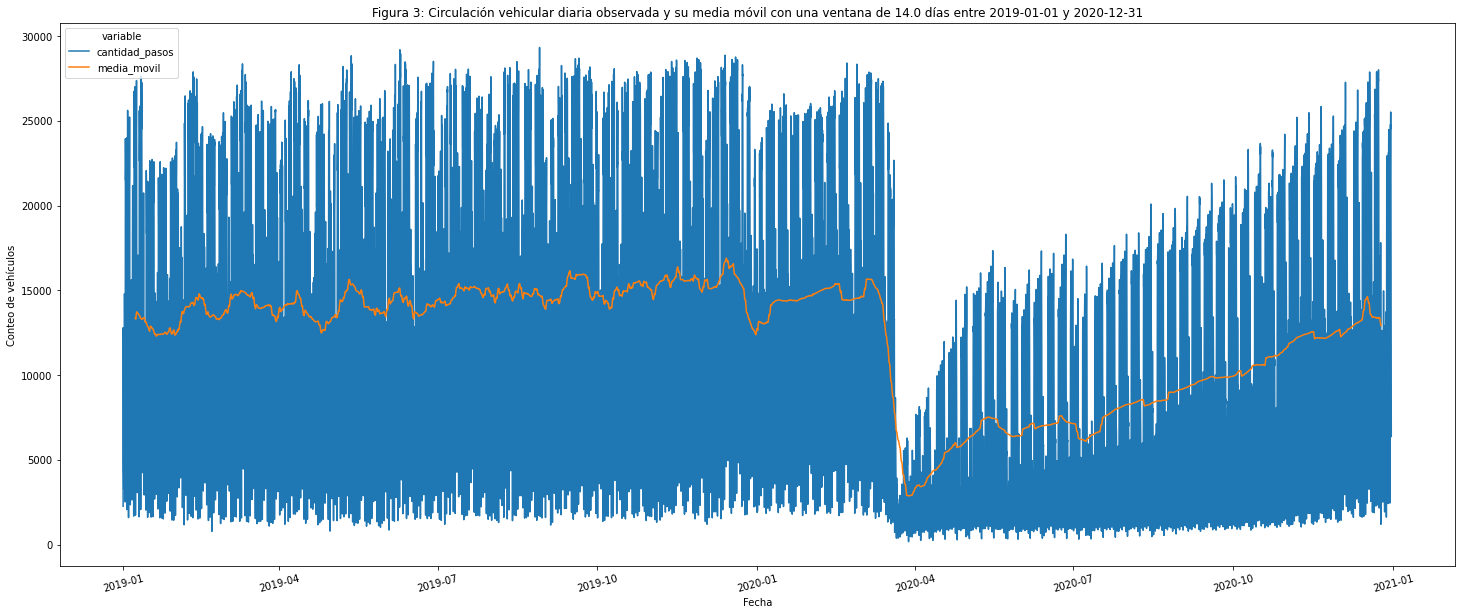

In [ ]:
##### Modifique las siguientes líneas de código #####
ancho_ventana = 24 * 14

fecha_inicial = '2019-01-01'
fecha_final = '2020-12-31'




##### NO modifique las siguientes líneas de código #####
vehiculos['media_movil'] = vehiculos['cantidad_pasos'].rolling(ancho_ventana, center = True).mean()

vehiculos_long = pd.melt(vehiculos, id_vars = 'fecha_hora', value_vars = ['cantidad_pasos', 'media_movil'])

vehiculos_acotado = vehiculos_long[(vehiculos_long['fecha_hora'] >= fecha_inicial) & (vehiculos_long['fecha_hora'] < fecha_final)]

plt.rcParams['figure.figsize'] = [25, 10]
sns.lineplot(x="fecha_hora", y="value", hue = 'variable', data=vehiculos_acotado)
plt.xticks(rotation=15)
plt.title('Figura 3: Circulación vehicular diaria observada y su media móvil con una ventana de ' + str(ancho_ventana / 24) + ' días entre ' + fecha_inicial + ' y ' + fecha_final)
plt.xlabel("Fecha")
plt.ylabel("Conteo de vehículos")
plt.show()

*   ¿Como pareciera ser el comportamiento anual? ¿Son suficientes estos datos para considerarlo un comportamiento típico o atípico de la circulación vehicular a lo largo de los años?
*   ¿A simple vista, como se modifica el sesgo de la media móvil como estimador de el conteo vehicular en función del ancho de la ventana?
*   ¿A simple vista, como se modifica su varianza?



Una forma de observar la estacionalidad de los datos es la autocorrelación de la variable. En este método se busca qué tanto correlaciona una variable consigo misma con un atraso en el tiempo (lag). Es decir, que se calcula la correlación de la variable con la misma variable con un lag de 1Hs, de 2 Hs, etc. El gráfico lag vs. correlacion se denomina **autocorrelograma**.

En el siguiente codigo se muestra un ejemplo animado de la construcción de un autocorrelograma:




In [ ]:
with open('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Imagenes/autocorrelation_example.gif','rb') as f:
    display.Image(data=f.read(), format='png')

Para la serie de conteno de vehículos, el autocorrelograma con lags de 0 a 336 Hs (3 semanas) es:


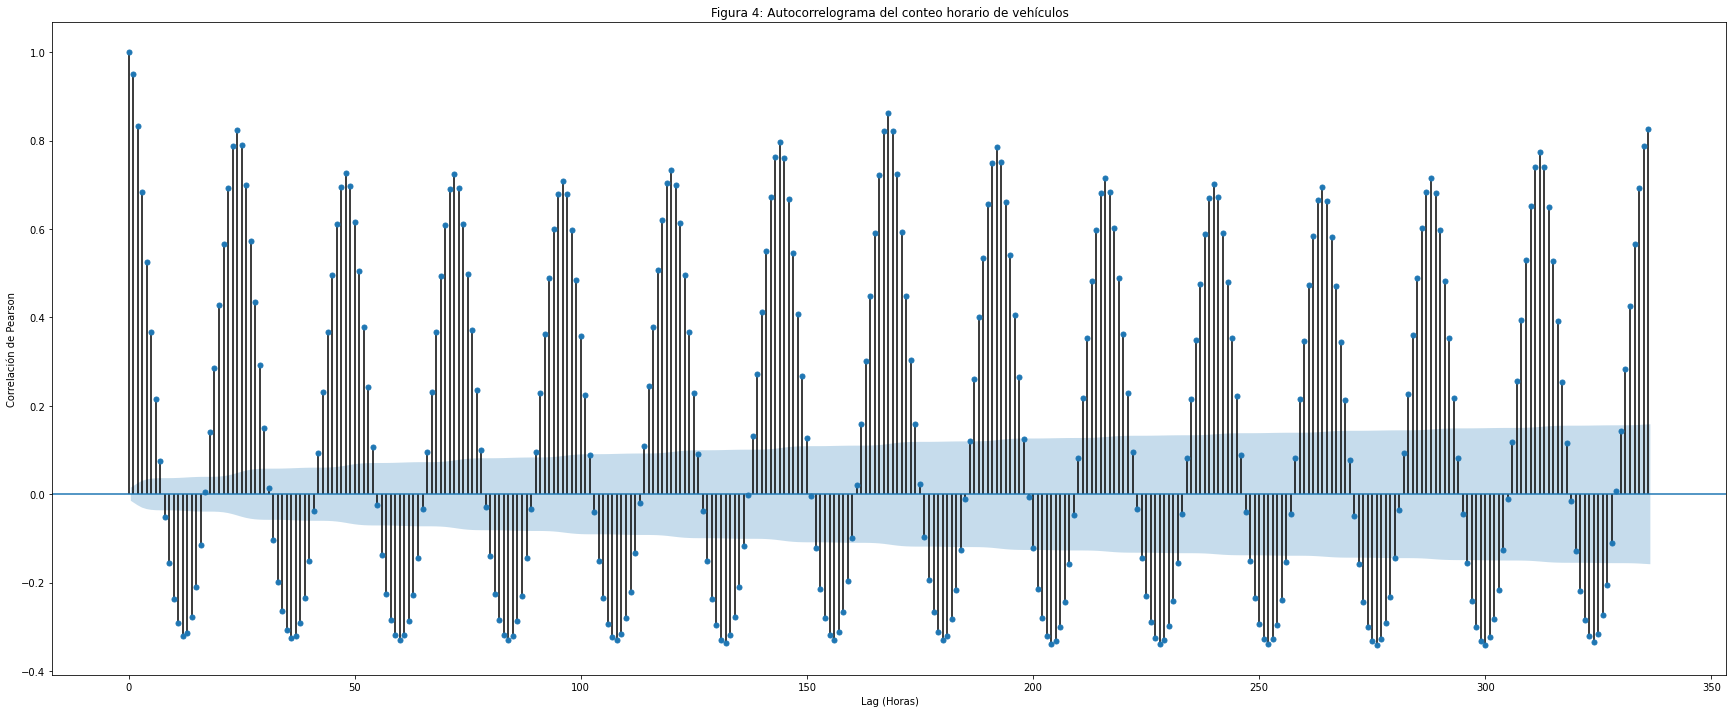

In [ ]:
plt.rcParams['figure.figsize'] = [30, 12]
plot_acf(vehiculos['cantidad_pasos'], lags = 24*7*2, title = 'Figura 4: Autocorrelograma del conteo horario de vehículos')
plt.xlabel("Lag (Horas)")
plt.ylabel("Correlación de Pearson")
plt.show();

*   ¿Por qué para lag = 0 la correlación es igual a 1?
*   ¿A cuanto lag se encuentran los picos de correlación más altos y bajos? ¿Son todos múltiplos de cuál valor? ¿Por qué?
*   ¿Por qué los picos de correlación negativa tienen valores absolutos menores a los de correlación positiva?
*   ¿Qué estacionalidades puede observar en el autocorrelograma?
*   ¿Que tan independiente es el conteo vehicular del tiempo?

Si bien con las correlaciones a distintos lags se pueden observar distintos estacionalidades, aquellos de mayor tiempo son más dificiles de detectar con una resolución temporal tan grande. A continuación se construyó otro autocorrelograma, a diferencia del anterior, este se construyó con los conteos vehiculares diarios, por lo que un lag = 1 equivale a 1 día y no a 1 hora.

Modifique las variables _lag_max_, _fecha_inicial_ y _fecha_final_ para variar el lag máximo del autocorrelograma y la fecha inicial y final respectivamente de los datos que se utilizarán para la construcción del correlograma.

Tenga en cuenta que _lag_max_ debe ser menor a la diferencia máxima de fechas, es decir que para los datos diarios de un año entero, _lag_max_ debe ser menor a 365.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


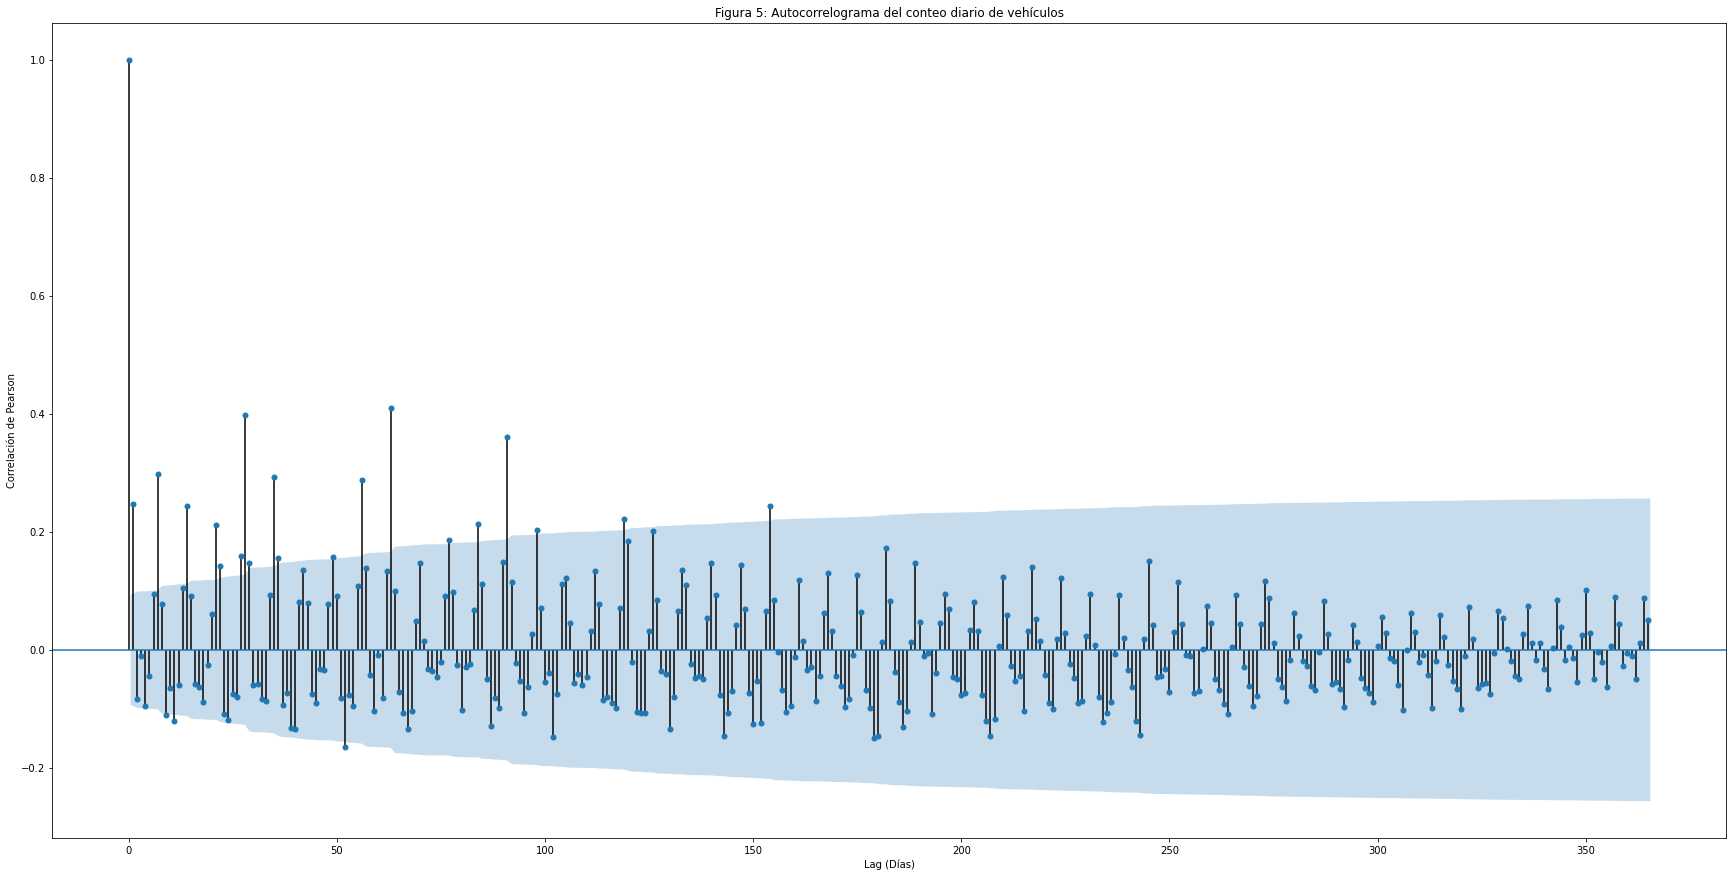

In [ ]:
##### Modifique las siguientes líneas de código #####
lag_max = 365
fecha_inicial = '2019-01-01'
fecha_final = '2020-03-20'



##### NO modifique las siguientes líneas de código #####
vehiculos_acotado = vehiculos[(vehiculos['fecha_hora'] >= fecha_inicial) & (vehiculos['fecha_hora'] < fecha_final)]
vehiculos_acotado['fecha'] = vehiculos_acotado['fecha_hora'].dt.date
vehiculos_acotado = vehiculos_acotado[['fecha', 'cantidad_pasos']].groupby(['fecha'], as_index = False).sum()

plt.rcParams['figure.figsize'] = [30, 15]
plot_acf(vehiculos_acotado['cantidad_pasos'], lags = lag_max, title = 'Figura 5: Autocorrelograma del conteo diario de vehículos')
plt.xlabel("Lag (Días)")
plt.ylabel("Correlación de Pearson")
plt.show();

*   ¿Qué estacionalidad se puede observar de forma más clara con esta resolución? ¿Cuál dejó de ser observable en comparación al autocorrelograma anterior?
*   ¿Cómo se ve alterado el correlograma si usted incluye los datos del período de cuarentena al realizar los cálculos?
*   ¿Existe una estacionalidad mensual?

# Preguntas de evaluación:
Entre al siguiente formulario, léalo atentamente y responda a la pregunta de evaluación en base a lo evidenciado en esta notebook:

https://forms.gle/JpncX5RtgvbdYfi2A